In [25]:
import polars as pl 
import polars_ds as pds
import polars_xdt as xdt
import polars.selectors as cs
import holidays
import os 
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.category")



## Read the data 

In [4]:
data = pl.read_csv('train.csv')

Clean the column names 

In [5]:
data = (data
.select(pl.all().name.map(lambda x:x.lower()))
.select(pl.all().name.map(lambda x:x.replace("-"," ")))
.select(pl.all().name.map(lambda x:x.replace(" ","_")))
)

data.head()

passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
str,str,bool,str,str,f64,bool,f64,f64,f64,f64,f64,str,bool
"""0001_01""","""Europa""",false,"""B/0/P""","""TRAPPIST-1e""",39.0,false,0.0,0.0,0.0,0.0,0.0,"""Maham Ofracculy""",false
"""0002_01""","""Earth""",false,"""F/0/S""","""TRAPPIST-1e""",24.0,false,109.0,9.0,25.0,549.0,44.0,"""Juanna Vines""",true
"""0003_01""","""Europa""",false,"""A/0/S""","""TRAPPIST-1e""",58.0,true,43.0,3576.0,0.0,6715.0,49.0,"""Altark Susent""",false
"""0003_02""","""Europa""",false,"""A/0/S""","""TRAPPIST-1e""",33.0,false,0.0,1283.0,371.0,3329.0,193.0,"""Solam Susent""",false
"""0004_01""","""Earth""",false,"""F/1/S""","""TRAPPIST-1e""",16.0,false,303.0,70.0,151.0,565.0,2.0,"""Willy Santantines""",true


## Relevant feature extraction

Split cabin into 3 columns (deck, num and side). In addition to this, I split the passengerid column to extract information about wheter or not the passenger are part of a family and which group. People which have same surnames and from one group are always one family.

In [6]:
# Split cabin column into 3 variables: deck, num and side and calculating total expense
data = (
data
.with_columns(cabin_split = pl.col('cabin').str.split("/"),
              passengerid_split = pl.col('passengerid').str.split("_"),
              name_split = pl.col('name').str.split(" "),
              total_expense = pl.col('roomservice')+pl.col('foodcourt')+pl.col('shoppingmall')+pl.col('spa')+pl.col('vrdeck'))
.with_columns(deck = pl.col('cabin_split').list.get(0),
              num =pl.col('cabin_split').list.get(1), 
              side = pl.col('cabin_split').list.get(2),
              group = pl.col('passengerid_split').list.get(0))
)



Checking the length of name_split list. The length of the list for all observations are 2, meaning that the second element is the surname.

In [7]:
(data
.filter(pl.col('name_split').is_not_null())
.select(
        len_max = pl.col('name_split').list.len().max(),
        len_min = pl.col('name_split').list.len().min()
        )
)

len_max,len_min
u32,u32
2,2


In [8]:
# Extract surname
data = data.with_columns(surname = pl.col('name_split').list.get(0))

# Creating a boolean which is 1 if the passenger is in a family, 0 otherwise
data = data.with_columns(family_ind = (pl.col('group').n_unique().over('surname')>1).cast(pl.Int64))

# Vip to boolean 
data = data.with_columns(pl.col('vip').cast(pl.Int64))

## Null values

Replacing empty values with null values. All null values will we replaced in sklearn pipeline.

In [9]:
# It is not possible to check if numeric columns contains empty data ("" or " ")
(data
 .select(pl.all().exclude(pl.String),
         pl.when(
    (cs.string()==" ")|(cs.string()==""))
            .then(pl.lit(None))
            .otherwise(cs.string())
            .name.keep())
.null_count()
)



cryosleep,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported,cabin_split,passengerid_split,name_split,total_expense,family_ind,passengerid,homeplanet,cabin,destination,name,deck,num,side,group,surname
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
217,179,203,181,183,208,183,188,0,199,0,200,908,0,0,201,199,182,200,199,199,199,0,200


In [10]:
# Checking unique passengers
data.select('passengerid').unique().shape[0]==data.shape[0]

True

## Descriptive statistics

### Homeplanet

The majority of the passengers comes from Earth (52 %).

<Axes: xlabel='homeplanet', ylabel='proportion'>

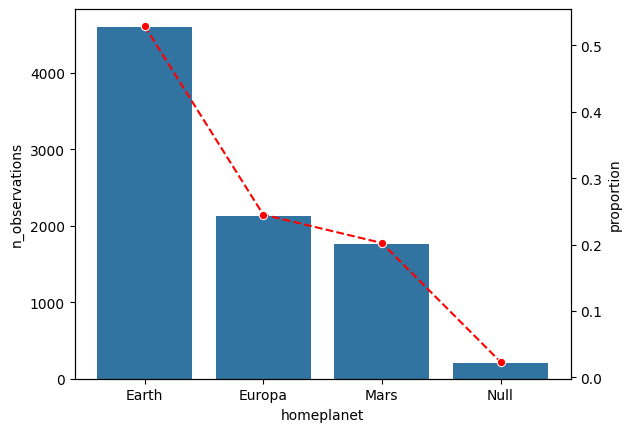

In [11]:
homeplanet = (data
.group_by('homeplanet')
.agg(pl.len().alias('n_observations'))
.with_columns((pl.col('n_observations')/pl.col('n_observations').sum()).alias('proportion'),
              pl.col('homeplanet').fill_null(pl.lit('Null')))
.sort(by ='n_observations',descending = True)
)

# Initialize plot
fig, ax = plt.subplots()

# Initialize the secondary axis
ax_twin = ax.twinx()

# Plot the first axis
sns.barplot(data=homeplanet.to_pandas(),x = 'homeplanet',y = 'n_observations',ax = ax)

# Plot the second axis
sns.lineplot(data=homeplanet.to_pandas(),
             x = 'homeplanet',
             y = 'proportion',
             ax = ax_twin,
             linestyle = '--',
             color = 'r',
             marker="o")

Lets look at the number of passengers who got transported, grouped by homeplanet

<Axes: xlabel='homeplanet', ylabel='n_observations'>

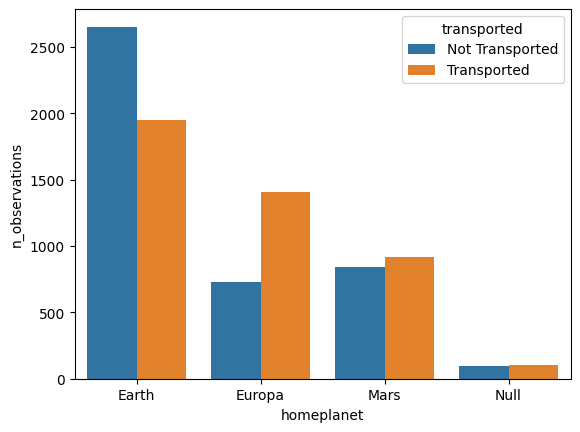

In [12]:
homeplanet_transported = (data
.group_by('homeplanet','transported')
.agg(pl.len().alias('n_observations'))
.sort(by =['homeplanet','n_observations'],descending = [False, True])
)

homeplanet_transported = (homeplanet_transported
.with_columns(pl.col('transported').cast(pl.Int64).replace(1,'Transported').replace(0,'Not Transported'),
              pl.when(pl.col('homeplanet').is_null()).then(pl.lit('Null')).otherwise(pl.col('homeplanet')).keep_name())
.with_columns(proportion = pl.col('n_observations')/pl.col('n_observations').over('transported').sum())
.sort(by = ['homeplanet','transported'])

)

sns.barplot(data = homeplanet_transported.to_pandas(),x = 'homeplanet',y = 'n_observations',hue = 'transported')


60% of the passengers did not have cryosleep.

<Axes: xlabel='cryosleep', ylabel='proportion'>

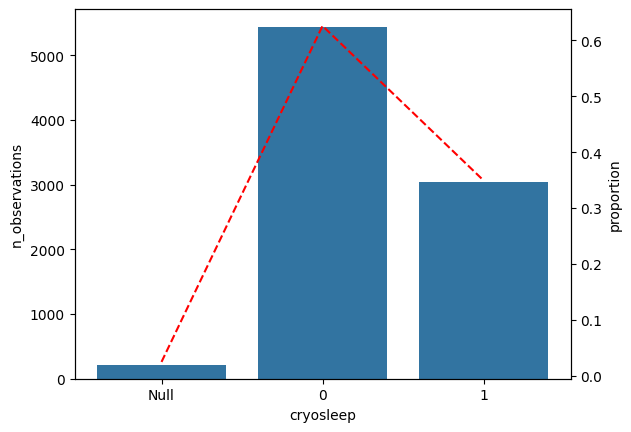

In [13]:
cryosleep = (data
.group_by(pl.col('cryosleep').cast(pl.Int64))
.agg(pl.len().alias('n_observations'))
.with_columns(pl.when(pl.col('cryosleep').is_null()).then(pl.lit('Null')).otherwise(pl.col('cryosleep')).keep_name(),
              (pl.col('n_observations')/pl.col('n_observations').sum()).alias('proportion')
              )
)


# Initialize plot
fig, ax = plt.subplots()

# Initialize the secondary axis
ax_twin = ax.twinx()

sns.barplot(data = cryosleep.to_pandas(),x = 'cryosleep',y = 'n_observations',ax = ax)
sns.lineplot(data = cryosleep.to_pandas(),x = 'cryosleep',y = 'proportion',
             ax = ax_twin,
             linestyle = '--',
             color = 'r',
             markers="o")

Below one can see that cryosleep could be an influential variable. Among those with no cryosleep, the majority did not get transported. 

<Axes: xlabel='cryosleep', ylabel='n_observations'>

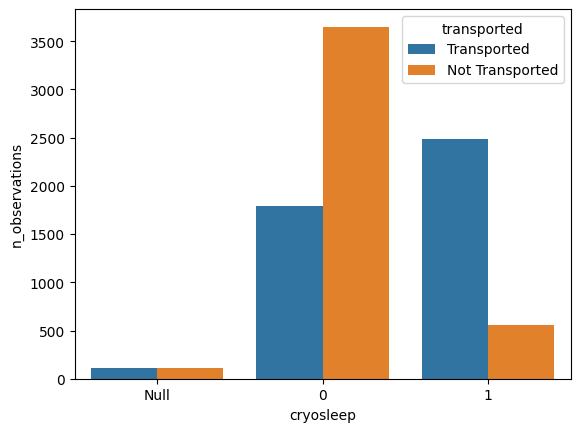

In [14]:
cryosleep_transported = (data
.group_by(pl.col('cryosleep').cast(pl.Int64),'transported')
.agg(pl.len().alias('n_observations'))
.with_columns(pl.when(pl.col('cryosleep').is_null()).then(pl.lit('Null')).otherwise(pl.col('cryosleep')).keep_name(),
              pl.col('transported').cast(pl.Int64).replace(1,'Transported').replace(0,'Not Transported')
              )
)

sns.barplot(data = cryosleep_transported.to_pandas(),x = 'cryosleep',y = 'n_observations',hue = 'transported')


Few VIP 

<Axes: xlabel='vip', ylabel='n_observations'>

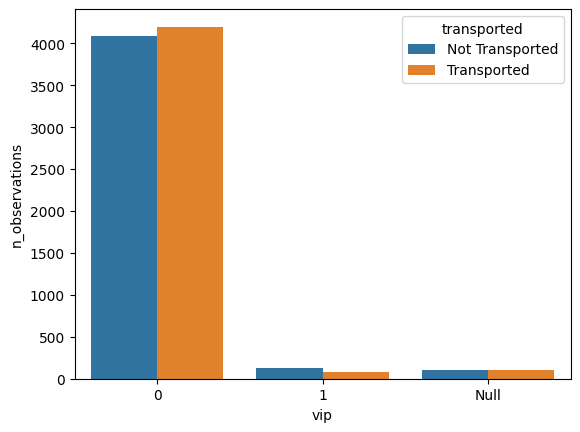

In [15]:
vip = (data
.group_by(pl.col('vip').cast(pl.Int64),'transported')
.agg(pl.len().alias('n_observations'))
.with_columns(pl.when(pl.col('vip').is_null()).then(pl.lit('Null')).otherwise(pl.col('vip')).keep_name(),
              pl.col('transported').cast(pl.Int64).replace(1,'Transported').replace(0,'Not Transported')
              )
)

sns.barplot(data = vip.to_pandas(),x = 'vip',y = 'n_observations',hue = 'transported')


Age distribution grouped by transported variable. The two distributions are almost identical

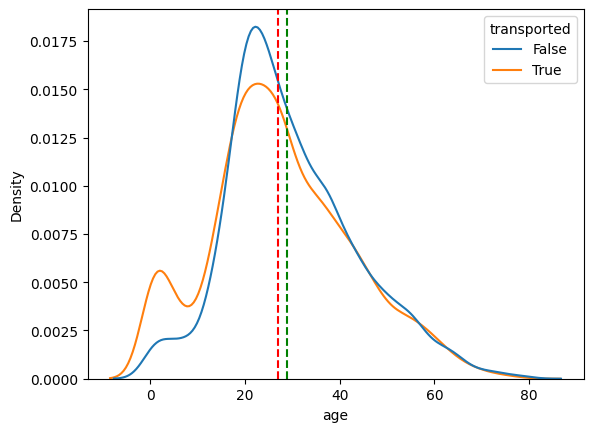

In [16]:
# Calculating mean and median age
age_stat = data.select(mean = pl.col('age').mean(),median = pl.col('age').median())

sns.kdeplot(data = data.to_pandas(),x = 'age',hue='transported')
plt.axvline(x=age_stat['median'][0], color='red', linestyle='--')
plt.axvline(x=age_stat['mean'][0], color='green', linestyle='--')




Age distribution grouped by homeplanet. Europe got a bit higher mean and median values compared to the other homeplanets. To replace missing values, one can condition on homeplanet. I will be looking at this in the ML step.

homeplanet,mean,median
str,f64,f64
"""Earth""",26.068232,23.0
"""Mars""",29.297203,28.0
"""Europa""",34.419664,33.0


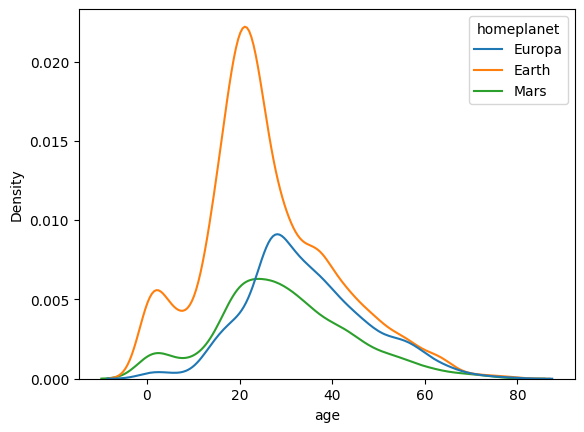

In [17]:
# Calculating mean and median age
age_homleplanet_stat = data.group_by('homeplanet').agg(mean = pl.col('age').mean(),median = pl.col('age').median()).filter(pl.col('homeplanet').is_not_null())

sns.kdeplot(data = data.to_pandas(),x = 'age',hue='homeplanet')
age_homleplanet_stat.head()

Alomst 70% of all destinations is TRAPPIST-1e. So, to replace the null values in this columns one can use the mode.

<Axes: xlabel='destination', ylabel='proportion'>

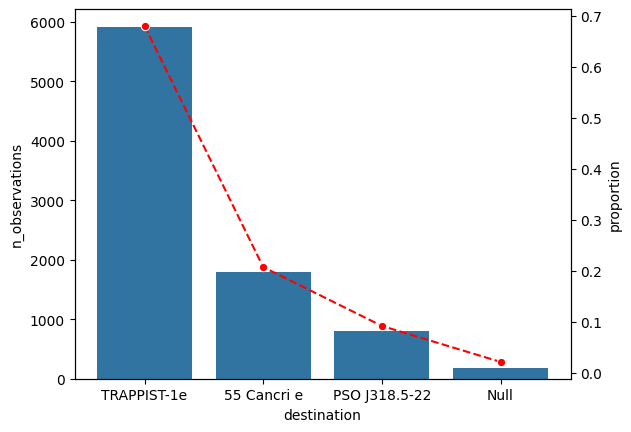

In [18]:
destination = (data
.group_by('destination')
.agg(pl.len().alias('n_observations'))
.with_columns((pl.col('n_observations')/pl.col('n_observations').sum()).alias('proportion'),
              pl.col('destination').fill_null(pl.lit('Null')))
.sort(by ='n_observations',descending = True)
)

# Initialize plot
fig, ax = plt.subplots()

# Initialize the secondary axis
ax_twin = ax.twinx()

# Plot the first axis
sns.barplot(data=destination.to_pandas(),x = 'destination',y = 'n_observations',ax = ax)

# Plot the second axis
sns.lineplot(data=destination.to_pandas(),
             x = 'destination',
             y = 'proportion',
             ax = ax_twin,
             linestyle = '--',
             color = 'r',
             marker="o")

Almost 50/50 by grouping on "transported" variable

<Axes: xlabel='destination', ylabel='n_observations'>

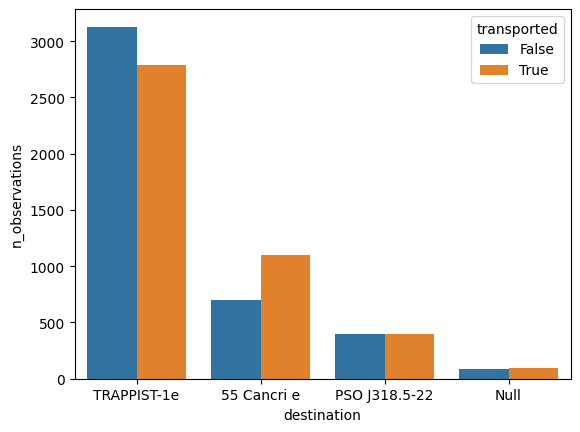

In [19]:
destination_transported = (data
.group_by('destination','transported')
.agg(pl.len().alias('n_observations'))
.with_columns(pl.col('destination').fill_null(pl.lit('Null')))
.sort(by ='n_observations',descending = True)
)

# Plot the first axis
sns.barplot(data=destination_transported.to_pandas(),x = 'destination',y = 'n_observations',hue='transported')


50/50 distribution between P and S

<Axes: xlabel='side', ylabel='proportion'>

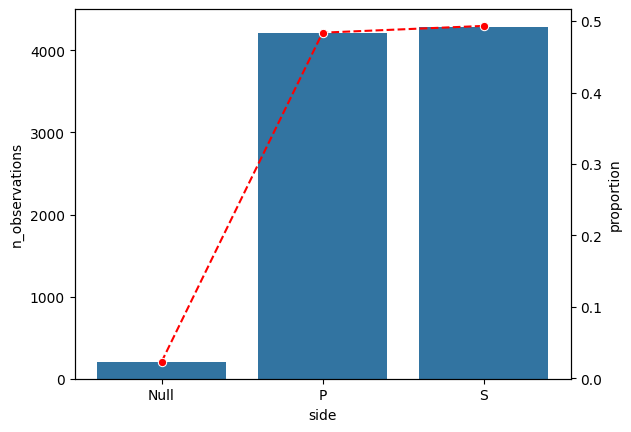

In [20]:
side = (data
.group_by('side')
.agg(pl.len().alias('n_observations')).sort(by = 'side')
.with_columns((pl.col('n_observations')/pl.col('n_observations').sum()).alias('proportion'),
              pl.col('side').fill_null(pl.lit('Null')))
)

# Initialize plot
fig, ax = plt.subplots()

# Initialize the secondary axis
ax_twin = ax.twinx()

# Plot the first axis
sns.barplot(data=side.to_pandas(),x = 'side',y = 'n_observations',ax = ax)

# Plot the second axis
sns.lineplot(data=side.to_pandas(),
             x = 'side',
             y = 'proportion',
             ax = ax_twin,
             linestyle = '--',
             color = 'r',
             marker="o")

Almost equally distributed when grouping at transported variable

<Axes: xlabel='side', ylabel='n_observations'>

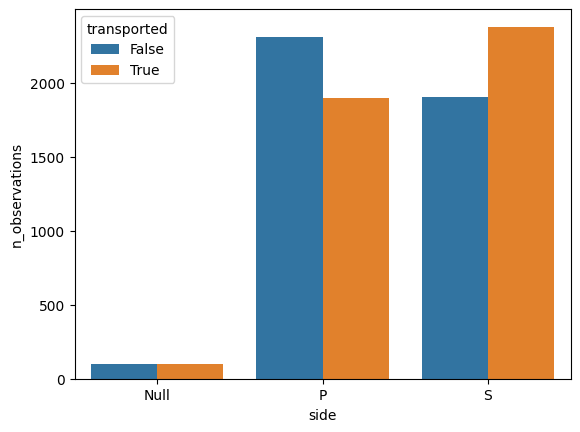

In [21]:
side_transported = (data
.group_by('side','transported')
.agg(pl.len().alias('n_observations')).sort(by = 'side')
.with_columns(pl.col('side').fill_null(pl.lit('Null')))
)

sns.barplot(data =side_transported.to_pandas(),x = 'side',y = 'n_observations',hue = 'transported')


Correlation matrix for numeric features

In [22]:
(data
.filter(
    (pl.col('age').is_not_null()) & 
        (pl.col('total_expense').is_not_null()))
.select('age', 'roomservice',	'foodcourt'	, 'shoppingmall', 'spa','vrdeck')
.corr()
)

age,roomservice,foodcourt,shoppingmall,spa,vrdeck
f64,f64,f64,f64,f64,f64
1.0,0.067215,0.131877,0.032528,0.123957,0.103424
0.067215,1.0,-0.015659,0.054898,0.011651,-0.01887
0.131877,-0.015659,1.0,-0.013888,0.223261,0.224416
0.032528,0.054898,-0.013888,1.0,0.014442,-0.004451
0.123957,0.011651,0.223261,0.014442,1.0,0.144365
0.103424,-0.01887,0.224416,-0.004451,0.144365,1.0


## ML

Define custom transformers

In [23]:
class estimator(BaseEstimator):

 def __init__(
     self, 
     estimator = RandomForestClassifier(),
 ):
     """
     A Custom BaseEstimator that can switch between classifiers.
     :param estimator: sklearn object - The classifier
     """ 
 
     self.estimator = estimator
 
 
 def fit(self, X, y=None, **kwargs):
     self.estimator.fit(X, y)
     return self
 
 
 def predict(self, X, y=None):
     return self.estimator.predict(X)
 
 
 def predict_proba(self, X):
     return self.estimator.predict_proba(X)
 
 
 def score(self, X, y):
     return self.estimator.score(X, y)
 
 

# Custom transformer for sklearn pipeline
class polars_onehot_encoding(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.column = column
        self.categories_ = {}

    def fit(self, X, y=None):
        # Find all unique values for each column and store them
        for col in self.column:
            self.categories_[col] = X[col].unique().to_list()
        return self

    def transform(self, X):
        # Ensure all categories are present in the dataframe
        for col, categories in self.categories_.items():
            for category in categories:
                X = X.with_columns(
                    (pl.col(col) == category).cast(pl.Int64).alias(f"{col}_{category}")
                )
        
        # Drop original columns
        X = X.drop(self.column)
        return X

# Mode imputer
class polars_impute_mode(BaseEstimator,TransformerMixin):
    def __init__(self,column):
        self.column = column 
        self.impute   = str()

    def fit(self,X,y = None):
     
     # Calculate mode for each column
     X_mode    = g = [(data
     .group_by(c)
     .agg(n_observations = pl.len())
     .sort(by = 'n_observations',descending = True)
     .head(1)
     .select(c)
     .item()
     ) for c in self.column]
    
     self.impute = X_mode
     return self
    
    def transform(self,X):
        # Impute the values
        X = X.with_columns(*[pl.col(c).fill_null(pl.lit(f)) for f,c in zip(self.impute,self.column)])
        return X

# Selecting features
class polars_feature_selector(BaseEstimator,TransformerMixin):
    def __init__(self,column):
        self.column = column

    def fit(self,X,y=None):
        return self 

    def transform(self,X):
        X = X.select(*self.column)
        return X    


Split into training and test

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data.clone(),
                                                     data.select(pl.col('transported').cast(pl.Int64)), 
                                                     test_size=0.20, 
                                                     random_state=42)

Define pipeline and run cross validation

In [57]:

# Relevant features
X_features = ['homeplanet','destination','cryosleep','side','age','roomservice','foodcourt','shoppingmall','spa','vrdeck']

pipeline_mode_one_hot = Pipeline(steps=[('feature_selector',polars_feature_selector(column=X_features)),
                                         ('mode_imputer_pl',polars_impute_mode(column=['homeplanet','destination','cryosleep','side'])),
                                         ('one_hot_encoding_pl',polars_onehot_encoding(column=['homeplanet','destination','cryosleep','side']))
                                         ]
                                         )

preprocessor = ColumnTransformer(transformers=[('mode_one_hot',pipeline_mode_one_hot,X_features)])


# Into final pipeline
pipeline = Pipeline([('preprocessor',preprocessor),
                     ('estimator',estimator())
                      ])

# Defining models and parameters
param = [

# XGBOOST
{
'estimator__estimator':[xgb.XGBRFClassifier()],
 'estimator__estimator__n_estimators':[100,200,400],
 'estimator__estimator__max_depth':[3,5,7],
 'estimator__estimator__subsample':[0.5,0.7],
 'estimator__estimator__colsample_bytree':[0.5,0.7,1],
 'estimator__estimator__learning_rate': [0.1,0.3],
  },

# Random Forest
{

 'estimator__estimator':[RandomForestClassifier()],
 'estimator__estimator__max_depth':[3,5],
 'estimator__estimator__n_estimators':[50,100],
 'estimator__estimator__min_samples_split':[2,3]


  },
  
  # Lightgbm
  {

    'estimator__estimator':[LGBMClassifier()],
    'estimator__estimator__num_leaves':[5,20,31],
    'estimator__estimator__learning_rate':[0.1,0.3,0.7],
    'estimator__estimator__n_estimators':[50,100,150]  

  },

# Decision tree
{

'estimator__estimator':[DecisionTreeClassifier()],


  }
]

gscv = GridSearchCV(pipeline, param, cv=5, n_jobs=12, return_train_score=False, verbose=3)

# Run CV
gscv.fit(X_train, y_train)



Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('mode_one_hot',
                                                                         Pipeline(steps=[('feature_selector',
                                                                                          polars_feature_selector(column=['homeplanet',
                                                                                                                          'destination',
                                                                                                                          'cryosleep',
                                                                                                                          'side',
                                                                                                                          'age',
                                                                                                                          'roomservice',
                                                                                                                          'foodcourt',
                                                                                                                          'shoppingmall',
                                                                                                                          'spa',
                                                                                                                          'vrdeck'])),
                                                                                         ('mode_imputer_pl',
                                                                                          polars_impute_mode(column=['homeplanet',
                                                                                                                     'des...
                          'estimator__estimator__max_depth': [3, 5],
                          'estimator__estimator__min_samples_split': [2, 3],
                          'estimator__estimator__n_estimators': [50, 100]},
                         {'estimator__estimator': [LGBMClassifier()],
                          'estimator__estimator__learning_rate': [0.1, 0.3,
                                                                  0.7],
                          'estimator__estimator__n_estimators': [50, 100, 150],
                          'estimator__estimator__num_leaves': [5, 20, 31]},
                         {'estimator__estimator': [DecisionTreeClassifier()]}],
             verbose=3)

In [58]:
# Få det beste estimatet
best_estimator = gscv.best_estimator_

# Best score
best_score = gscv.best_score_

# Best params
best_params = gscv.best_params_

# Resultater for hver kombinasjon av parametere
results = gscv.cv_results_
